# uci_models.ipynb

The purpose of this file is to create a logistic regression and support vector machine model based on the normalized UCI dataset found in MLP2.

## Authors
1. Riley Cullen
2. Mason Adsero

## Data

In [57]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

uci_df = pd.read_csv("../MLP2/input/heart_disease_uci_normalized.csv")
X = np.c_[uci_df.drop("num", axis = 1)]
y = np.c_[uci_df["num"]]

target_names = ['No Heart Disease', 'Has Heart Disease']

print("X shape: ", X.shape)
print("y shape: ", y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)



X shape:  (920, 33)
y shape:  (920, 1)
X_train shape:  (644, 33)
X_test shape:  (276, 33)
y_train shape:  (644, 1)
y_test shape:  (276, 1)


In [58]:
from dataclasses import dataclass

@dataclass
class MetricContainer:
    name: str
    precision: float = 0
    recall: float = 0
    f1_score: float = 0

def average_classification_report(arr: list):
    no_hd = MetricContainer('No Heart Disease')
    has_hd = MetricContainer('Has Heart Disease')

    for elem in arr:
        no_hd.precision += elem['No Heart Disease']['precision']
        no_hd.recall += elem['No Heart Disease']['recall']
        no_hd.f1_score += elem['No Heart Disease']['f1-score']

        has_hd.precision += elem['Has Heart Disease']['precision']
        has_hd.recall += elem['Has Heart Disease']['recall']
        has_hd.f1_score += elem['Has Heart Disease']['f1-score']   

    size = len(arr)
    no_hd.precision /= size
    no_hd.recall /= size
    no_hd.f1_score /= size

    has_hd.precision /= size
    has_hd.recall /= size
    has_hd.f1_score /= size

    print(no_hd)
    print(has_hd)

    return has_hd.recall

def find_optimal_value(values: list, report: list) -> int:
    optimal_value = values[0]
    recall = report[0]

    for idx, val in enumerate(values[0:]):
        if (report[idx] > recall):
            optimal_value = val
            recall = report[idx]
    return optimal_value

## Logistic Regression Model

### Find optimal parameters using 10-fold cross validation
Given the application area (medical classification), we look for the optimal parameters that maximize recall of the "Has Heart Disease" class.

#### Finding the optimal number of max iterations

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

kf = KFold(n_splits=10, random_state=None, shuffle=True)
iter_values = [100, 500, 1000]
iter_report = []

for iter in iter_values:
    logreg = LogisticRegression(max_iter=iter)
    report = []
    for train_id, test_id in kf.split(X_train):
        
        X_train_kf, X_test_kf = X_train[train_id], X_train[test_id]
        y_train_kf, y_test_kf = y_train[train_id], y_train[test_id]

        logreg.fit(X_train_kf, y_train_kf.ravel())

        y_pred = logreg.predict(X_test_kf)

        report.append(classification_report(y_test_kf, y_pred, target_names=target_names, output_dict=True))
    print("Average report at iter = ", iter)
    iter_report.append(average_classification_report(report))

optimal_iter_logreg = find_optimal_value(iter_values, iter_report)
print(optimal_iter_logreg)

Average report at iter =  100
MetricContainer(name='No Heart Disease', precision=0.8231410256410255, recall=0.806667984792985, f1_score=0.8129041147239382)
MetricContainer(name='Has Heart Disease', precision=0.8516924854773154, recall=0.8651540220513055, f1_score=0.8570490921795269)
Average report at iter =  500
MetricContainer(name='No Heart Disease', precision=0.81201483640051, recall=0.8075397952152654, f1_score=0.8075996671622641)
MetricContainer(name='Has Heart Disease', precision=0.8450259314894039, recall=0.8527099339693347, f1_score=0.8478160730495331)
Average report at iter =  1000
MetricContainer(name='No Heart Disease', precision=0.825209366499689, recall=0.8083301502394941, f1_score=0.8131375365947984)
MetricContainer(name='Has Heart Disease', precision=0.8563709475938577, recall=0.8678482435275677, f1_score=0.8601312082784982)
1000


#### Finding the optimal regularization parameter

In [60]:
c_values = [0.5, 1, 5, 10, 100]
c_report = []

for c in c_values:
    logreg = LogisticRegression(C=c)
    report = []
    for train_id, test_id in kf.split(X_train):
        
        X_train_kf, X_test_kf = X_train[train_id], X_train[test_id]
        y_train_kf, y_test_kf = y_train[train_id], y_train[test_id]

        logreg.fit(X_train_kf, y_train_kf.ravel())

        y_pred = logreg.predict(X_test_kf)

        report.append(classification_report(y_test_kf, y_pred, target_names=target_names, output_dict=True))
    print("Average report at iter = ", c)
    c_report.append(average_classification_report(report))

optimal_c_logreg = find_optimal_value(c_values, c_report)
print(optimal_c_logreg)

Average report at iter =  0.5
MetricContainer(name='No Heart Disease', precision=0.8231570560123691, recall=0.7901829194501608, f1_score=0.8055294956941055)
MetricContainer(name='Has Heart Disease', precision=0.8420614150634819, recall=0.8665864561994594, f1_score=0.8536415157435158)
Average report at iter =  1
MetricContainer(name='No Heart Disease', precision=0.8393218207745943, recall=0.7956049936683648, f1_score=0.8145067136965128)
MetricContainer(name='Has Heart Disease', precision=0.8466502149428979, recall=0.8844232966076582, f1_score=0.8636312338188772)
Average report at iter =  5
MetricContainer(name='No Heart Disease', precision=0.824238156767634, recall=0.8126715388183687, f1_score=0.8168802067230718)
MetricContainer(name='Has Heart Disease', precision=0.8589393466817448, recall=0.8649179142929142, f1_score=0.8610170003037269)


c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Average report at iter =  10
MetricContainer(name='No Heart Disease', precision=0.8165430787841196, recall=0.8077590340076435, f1_score=0.8090945410695378)
MetricContainer(name='Has Heart Disease', precision=0.8568997888990101, recall=0.8625612576812267, f1_score=0.8578494998266379)


c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Average report at iter =  100
MetricContainer(name='No Heart Disease', precision=0.8197142467727175, recall=0.8004527363706886, f1_score=0.8080752533235982)
MetricContainer(name='Has Heart Disease', precision=0.8571603810304497, recall=0.8690622928762981, f1_score=0.861716016205112)
1


c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

### Train model using optimal parameters

In [61]:
logreg = LogisticRegression(max_iter=optimal_iter_logreg, C=optimal_c_logreg)
logreg.fit(X_train, y_train)

c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1, max_iter=1000)

### Evaluation on test data

In [62]:
y_pred = logreg.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred, labels=[1, 0])
print(confusion_mat, "\n\n")

print(classification_report(y_test, y_pred, target_names=target_names))

class_report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)

class_df = pd.DataFrame(class_report).transpose()
class_df.to_csv('./results/uci_logreg_classification_report_test.csv')

[[126  20]
 [ 34  96]] 


                   precision    recall  f1-score   support

 No Heart Disease       0.83      0.74      0.78       130
Has Heart Disease       0.79      0.86      0.82       146

         accuracy                           0.80       276
        macro avg       0.81      0.80      0.80       276
     weighted avg       0.81      0.80      0.80       276



Accuracy =  0.8905690200210747


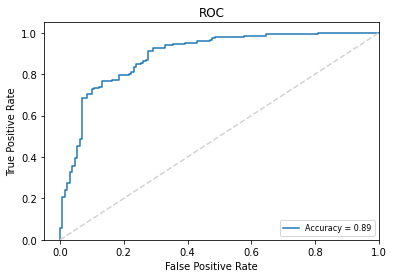

In [63]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
y_score = logreg.predict_proba(X_test)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_score[:,1])

roc_auc = auc(false_positive_rate, true_positive_rate)

print('Accuracy = ', roc_auc)

# Plotting
plt.title('ROC')
plt.plot(false_positive_rate, true_positive_rate, label=('Accuracy = %0.2f'%roc_auc))
plt.legend(loc='lower right', prop={'size':8})
plt.plot([0,1],[0,1], color='lightgrey', linestyle='--')
plt.xlim([-0.05,1.0])
plt.ylim([0.0,1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("./results/uci_logreg_roc_test.png", bbox_inches='tight', transparent=False, facecolor='white')
plt.show()

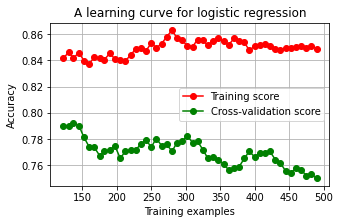

In [64]:
from sklearn.model_selection import learning_curve

train_sizes = np.linspace(0.2, 0.8, 50)

train_sizes, train_mse, test_mse = learning_curve(logreg, X, y.ravel(), 
                                    train_sizes = train_sizes, 
                                    scoring='accuracy', 
                                    cv=3, shuffle=True)

train_scores = train_mse
test_scores = test_mse

#print(train_scores)
#print(test_scores)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot learning curve
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    
ax.set_title('A learning curve for logistic regression')
ax.set_xlabel("Training examples")
ax.set_ylabel("Accuracy")
ax.grid()

ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
ax.legend(loc="best")

plt.savefig("./results/uci_logreg_learning_curve.png", bbox_inches='tight', transparent=False, facecolor='white')
plt.show()

## Support Vector Machine

### Train and Validate Model

In [65]:
from sklearn.svm import LinearSVC

c_report = []

for c in c_values:
    svm = LinearSVC(C=c)
    report = []

    print("Training at C = ", c)

    for train_id, test_id in kf.split(X_train):
        
        X_train_kf, X_test_kf = X_train[train_id], X_train[test_id]
        y_train_kf, y_test_kf = y_train[train_id], y_train[test_id]

        svm.fit(X_train_kf, y_train_kf.ravel())

        y_pred = svm.predict(X_test_kf)
        
        confusion_mat = confusion_matrix(y_test_kf, y_pred)

        report.append(classification_report(y_test_kf, y_pred, target_names=target_names, output_dict=True))

    print("Average report at C = ", c)
    c_report.append(average_classification_report(report))

optimal_c_svm = find_optimal_value(c_values, c_report)
print(optimal_c_svm)

Training at C =  0.5
Average report at C =  0.5
MetricContainer(name='No Heart Disease', precision=0.8267833994378737, recall=0.8124707398985098, f1_score=0.8147716902841322)
MetricContainer(name='Has Heart Disease', precision=0.8535091172502088, recall=0.8590241439215539, f1_score=0.8538482087309532)
Training at C =  1
Average report at C =  1
MetricContainer(name='No Heart Disease', precision=0.8215489044424136, recall=0.8144820768157809, f1_score=0.812710645368927)
MetricContainer(name='Has Heart Disease', precision=0.8576438110691178, recall=0.8633811613223378, f1_score=0.8574646457608294)
Training at C =  5


c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warni

Average report at C =  5
MetricContainer(name='No Heart Disease', precision=0.8087248728746227, recall=0.8203810540550158, f1_score=0.8089607402598432)
MetricContainer(name='Has Heart Disease', precision=0.8561558397742608, recall=0.8538268839187818, f1_score=0.8518261930248665)
Training at C =  10


c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warni

Average report at C =  10
MetricContainer(name='No Heart Disease', precision=0.8219953031717738, recall=0.8154326836956148, f1_score=0.8144364172283668)
MetricContainer(name='Has Heart Disease', precision=0.8630506645025596, recall=0.8612870891096698, f1_score=0.8598662937447683)
Training at C =  100


c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warni

Average report at C =  100
MetricContainer(name='No Heart Disease', precision=0.8225872630284394, recall=0.7542946728316092, f1_score=0.7644481397051867)
MetricContainer(name='Has Heart Disease', precision=0.8245606905568954, recall=0.8494005698779261, f1_score=0.8259266750585079)
1


c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### Train model using optimal regularization parameter

In [66]:
svm = LinearSVC(C=optimal_c_svm).fit(X_train, y_train)

c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Test model

In [67]:
y_pred = svm.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred, labels=[1, 0])
print(confusion_mat, "\n\n")

print(classification_report(y_test, y_pred, target_names=target_names))

class_report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)

class_df = pd.DataFrame(class_report).transpose()
class_df.to_csv('./results/uci_svm_classification_report_test.csv')

[[121  25]
 [ 35  95]] 


                   precision    recall  f1-score   support

 No Heart Disease       0.79      0.73      0.76       130
Has Heart Disease       0.78      0.83      0.80       146

         accuracy                           0.78       276
        macro avg       0.78      0.78      0.78       276
     weighted avg       0.78      0.78      0.78       276



Accuracy =  0.8932560590094837


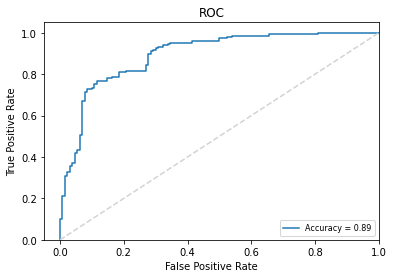

In [68]:
y_score = svm.decision_function(X_test)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_score)

roc_auc = auc(false_positive_rate, true_positive_rate)

print('Accuracy = ', roc_auc)

# Plotting
plt.title('ROC')
plt.plot(false_positive_rate, true_positive_rate, label=('Accuracy = %0.2f'%roc_auc))
plt.legend(loc='lower right', prop={'size':8})
plt.plot([0,1],[0,1], color='lightgrey', linestyle='--')
plt.xlim([-0.05,1.0])
plt.ylim([0.0,1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("./results/uci_svm_roc_test.png", bbox_inches='tight', transparent=False, facecolor='white')
plt.show()

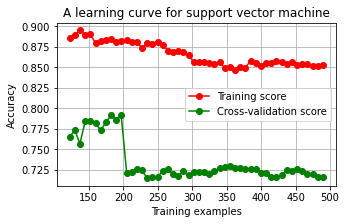

In [69]:
train_sizes = np.linspace(0.2, 0.8, 50)

train_sizes, train_mse, test_mse = learning_curve(svm, X, y.ravel(), 
                                    train_sizes = train_sizes, 
                                    scoring='accuracy', 
                                    cv=3, shuffle=True)

train_scores = train_mse
test_scores = test_mse

#print(train_scores)
#print(test_scores)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot learning curve
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    
ax.set_title('A learning curve for support vector machine')
ax.set_xlabel("Training examples")
ax.set_ylabel("Accuracy")
ax.grid()

ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
ax.legend(loc="best")

plt.savefig("./results/uci_svm_learning_curve.png", bbox_inches='tight', transparent=False, facecolor='white')
plt.show()

## Decision Tree (Entropy)

### Train and Validate Model

In [70]:
from sklearn.tree import DecisionTreeClassifier

depth_values = [1, 2, 3, 4, 5, 10, 12]
depth_report = []

for d in depth_values:
    dtclf = DecisionTreeClassifier(max_depth=d)
    report = []

    print("Training at Depth = ", d)

    for train_id, test_id in kf.split(X_train):
        
        X_train_kf, X_test_kf = X_train[train_id], X_train[test_id]
        y_train_kf, y_test_kf = y_train[train_id], y_train[test_id]

        dtclf.fit(X_train_kf, y_train_kf.ravel())

        y_pred = dtclf.predict(X_test_kf)
        
        confusion_mat = confusion_matrix(y_test_kf, y_pred)

        report.append(classification_report(y_test_kf, y_pred, target_names=target_names, output_dict=True))

    print("Average report at depth = ", d)
    depth_report.append(average_classification_report(report))

optimal_depth_dt = find_optimal_value(depth_values, depth_report)
print(optimal_depth_dt)

Training at Depth =  1
Average report at depth =  1
MetricContainer(name='No Heart Disease', precision=0.7045297393019102, recall=0.7301139977467842, f1_score=0.7153074182490317)
MetricContainer(name='Has Heart Disease', precision=0.7901935448276911, recall=0.7655925429971624, f1_score=0.7764109585022526)
Training at Depth =  2
Average report at depth =  2
MetricContainer(name='No Heart Disease', precision=0.684387430531643, recall=0.7430516258964535, f1_score=0.7094768370174717)
MetricContainer(name='Has Heart Disease', precision=0.7903873554524605, recall=0.7276342518989577, f1_score=0.7554129173637949)
Training at Depth =  3
Average report at depth =  3
MetricContainer(name='No Heart Disease', precision=0.7608804770937123, recall=0.7285895761155504, f1_score=0.7384246168673072)
MetricContainer(name='Has Heart Disease', precision=0.797145901335982, recall=0.816351079009842, f1_score=0.8032205505810094)
Training at Depth =  4
Average report at depth =  4
MetricContainer(name='No Heart

In [71]:
dtclf = DecisionTreeClassifier(max_depth=optimal_depth_dt).fit(X_train, y_train)

### Test Model

In [72]:
y_pred = dtclf.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred, labels=[1, 0])
print(confusion_mat, "\n\n")

print(classification_report(y_test, y_pred, target_names=target_names))

class_report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)

class_df = pd.DataFrame(class_report).transpose()
class_df.to_csv('./results/uci_dt_classification_report_test.csv')

[[130  16]
 [ 46  84]] 


                   precision    recall  f1-score   support

 No Heart Disease       0.84      0.65      0.73       130
Has Heart Disease       0.74      0.89      0.81       146

         accuracy                           0.78       276
        macro avg       0.79      0.77      0.77       276
     weighted avg       0.79      0.78      0.77       276



In [73]:
print(dtclf.tree_.max_depth)

3


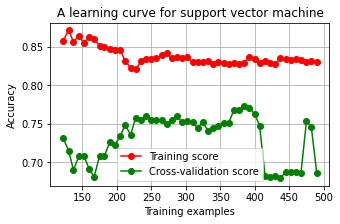

In [74]:
train_sizes = np.linspace(0.2, 0.8, 50)

train_sizes, train_mse, test_mse = learning_curve(dtclf, X, y.ravel(), 
                                    train_sizes = train_sizes, 
                                    scoring='accuracy', 
                                    cv=3, shuffle=True)

train_scores = train_mse
test_scores = test_mse

#print(train_scores)
#print(test_scores)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot learning curve
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    
ax.set_title('A learning curve for support vector machine')
ax.set_xlabel("Training examples")
ax.set_ylabel("Accuracy")
ax.grid()

ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
ax.legend(loc="best")

plt.savefig("./results/uci_dt_learning_curve.png", bbox_inches='tight', transparent=False, facecolor='white')
plt.show()

### Feature importance

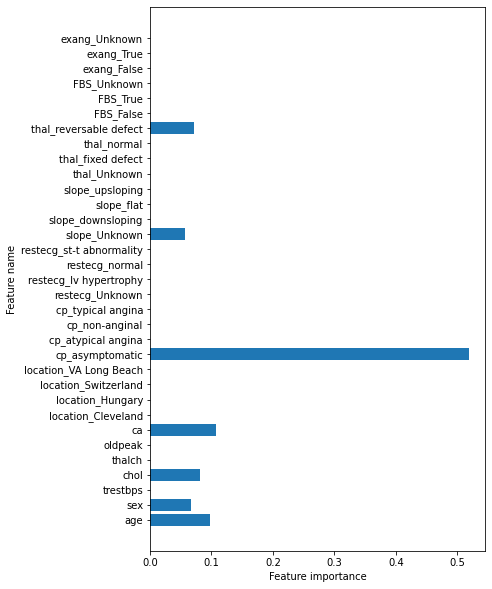

In [75]:
# plot important features
def plot_feature_importances(clf, feature_names):
    c_features = len(feature_names)
    plt.figure(figsize=(6, 10))
    plt.barh(range(c_features), clf.feature_importances_)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature name")
    plt.yticks(np.arange(c_features), feature_names, fontsize=10)

cols = uci_df.drop("num", axis=1).columns

# call the function above
plot_feature_importances(dtclf, cols)
plt.savefig("./results/uci_tree_important_features.png", bbox_inches='tight', transparent=False, facecolor='white')
plt.show()